<a href="https://colab.research.google.com/github/rahiakela/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/blob/14-deep-computer-vision-using-convolutional-neural-networks/1_convolutional_and_pooling_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Computer Vision: Convolutional & Pooling Layers

Although IBM’s Deep Blue supercomputer beat the chess world champion Garry Kasparov back in 1996, it wasn’t until fairly recently that computers were able to reliably perform seemingly trivial tasks such as detecting a puppy in a picture or recognizing spoken words. 

Why are these tasks so effortless to us humans? 

The answer lies in the fact that perception largely takes place outside the realm of our consciousness, within specialized visual, auditory, and other sensory modules in our brains. By the time sensory information reaches our consciousness, it is already adorned with high-level features.

For example, when you look at a picture of a cute puppy, you cannot choose
not to see the puppy, not to notice its cuteness. Nor can you explain how you recognize a cute puppy; it’s just obvious to you. Thus, we cannot trust our subjective experience: perception is not trivial at all, and to understand it we must look at how the sensory modules work.

Convolutional neural networks (CNNs) emerged from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s. 

In the last few years, thanks to the increase in computational power, the amount of available training data, and the tricks for training deep nets, CNNs have managed to achieve superhuman performance on some complex visual tasks. They power image search services, self-driving cars, automatic video classification systems, and more. 

Moreover, CNNs are not restricted to visual perception: they are also successful at many other tasks, such as voice recognition and natural language processing. However, we will focus on visual applications for now.

We will explore where CNNs came from, what their building blocks look like, and how to implement them using TensorFlow and Keras. Then we will discuss
some of the best CNN architectures, as well as other visual tasks, including:

1. object detection (classifying multiple objects in an image and placing bounding boxes around them) 
2. and semantic segmentation (classifying each pixel according to the
class of the object it belongs to).

## Setup

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

A couple utility functions to plot grayscale and RGB images:

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## What is a Convolution?

The studies of the visual cortex inspired the [neocognitron](https://www.cs.princeton.edu/courses/archive/spr08/cos598B/Readings/Fukushima1980.pdf), introduced in 1980, which gradually evolved into what we now call convolutional neural networks. 

An important milestone was a [1998 paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) by Yann LeCun et al. that introduced the famous LeNet-5 architecture, widely used by banks to recognize handwritten check numbers. This architecture has some building blocks, such as fully connected layers and sigmoid activation functions, but it also introduces two new building blocks: convolutional layers and pooling layers.



## Convolutional Layers

The most important building block of a CNN is the convolutional layer: neurons in the first convolutional layer are not connected to every single pixel in the input image, but only to pixels in their receptive fields.

In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer.

This architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on. This hierarchical structure is common in real-world images, which is one of the reasons why CNNs work so well for image recognition.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/local-receptive-fields.png?raw=1' width='800'/>

A neuron located in row i, column j of a given layer is connected to the outputs of the neurons in the previous layer located in rows $i$ to $j + f_{\mathbf{h}} - 1$, columns $j$ to $j + f_{\mathbf{w}} - 1$, where fh and fw are the height and width of the receptive field.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/zero-padding.png?raw=1' width='800'/>

In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs, as shown in the diagram. This is called zero padding.

It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields.This dramatically reduces the model’s
computational complexity. The shift from one receptive field to the next is called the stride.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/stride.png?raw=1' width='800'/>

In the diagram, a 5 × 7 input layer (plus zero padding) is connected to a 3 × 4 layer, using 3 × 3 receptive fields and a stride of 2 (in this example the stride is the same in both directions, but it does not have to be so). A neuron located in row $i$, column $j$ in the upper layer is connected to the outputs of the neurons in the previous layer located in rows $i *  s_{\mathbf{h}}$ to $i *  s_{\mathbf{h}} + f_{\mathbf{h}} -1$, columns $j *  s_{\mathbf{w}}$ to $j *  s_{\mathbf{w}} + f_{\mathbf{w}} -1$, where $s_{\mathbf{h}}$ and $s_{\mathbf{w}}$ are the vertical and horizontal strides.




## Filters

A neuron’s weights can be represented as a small image the size of the receptive field.

For example, the figure below shows two possible sets of weights, called filters (or convolution kernels). The first one is represented as a black square with a vertical white line in the middle (it is a 7 × 7 matrix full of 0s except for the central column, which is full of 1s); neurons using these weights will ignore everything in their receptive field except
for the central vertical line (since all inputs will get multiplied by 0, except for the ones located in the central vertical line).

The second filter is a black square with a horizontal white line in the middle. Once again, neurons using these weights will ignore everything in their receptive field except for the central horizontal line.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/feature-maps.png?raw=1' width='800'/>

## Stacking Multiple Feature Maps

Up to now, for simplicity, I have represented the output of each convolutional layer as a 2D layer, but in reality a convolutional layer has multiple filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in 3D.

It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the same weights and bias term).

Neurons in different feature maps use different parameters. A neuron’s receptive field is the same as described earlier, but it extends across all the previous layers’ feature maps. In short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/multiple-feature-maps.png?raw=1' width='800'/>

Input images are also composed of multiple sublayers: one per color channel. There are typically three: red, green, and blue (RGB). Grayscale images have just one channel, but some images may have much more—for example, satellite images that capture extra light frequencies (such as infrared).

Specifically, a neuron located in row $i$, column $j$ of the feature map $k$ in a given convolutional layer l is connected to the outputs of the neurons in the previous layer $l – 1$, located in rows $i × s_{\mathbf{h}}$ to $i × s_{\mathbf{h}} + f_{\mathbf{h}} – 1$ and columns $j × s_{\mathbf{w}}$ to $j × s_{\mathbf{w}} + f_{\mathbf{w}} – 1$, across all feature maps (in layer $l – 1$). Note that all neurons located in the same row i and column
j but in different feature maps are connected to the outputs of the exact same neurons in the previous layer.

The below equation summarizes the preceding explanations in one big mathematical equation: it shows how to compute the output of a given neuron in a convolutional layer. It is a bit ugly due to all the different indices, but all it does is calculate the weighted sum of all the inputs, plus the bias term.

$ z_{i,j,k} = b_k + \sum\limits_{u = 0}^{f_h - 1} \, \, \sum\limits_{v = 0}^{f_w - 1} \, \, \sum\limits_{k' = 0}^{f_{n'} - 1} \, \, x_{i', j', k'} \times w_{u, v, k', k} \quad \text{with } \begin{cases} i' = i \times s_h + u \\ j' = j \times s_w + v \end{cases} $

In this equation:

* $Z_{i,j,k}$ is the output of the neuron located in row $i$, column $j$ in feature map $k$ of the convolutional layer (layer $l$).
* $s_{\mathbf{h}}$ and $s_{\mathbf{s}}$ are the vertical and horizontal strides, $f_{\mathbf{h}}$ and $f_{\mathbf{w}}$ are the height and width of the receptive field, and $f_{\mathbf{n′}}$ is the number of feature maps
in the previous layer (layer $l – 1$).
* $X_{i′, j′, k′}$ is the output of the neuron located in layer $l – 1$, row $i′$, column $j′$, feature map $k′$ (or channel $k′$ if the previous layer is the input layer).
* $b_{k}$ is the bias term for feature map $k$ (in layer $l$). You can think of it as a knob that tweaks the overall brightness of the feature map $k$.
* $W_{u, v, k′ ,k}$ is the connection weight between any neuron in feature map $k$ of the layer $l$ and its input located at row $u$, column $v$ (relative to the neuron’s receptive field), and feature map $k′$.

## TensorFlow Implementation

In TensorFlow, each input image is typically represented as a 3D tensor of shape [height, width, channels].A mini-batch is represented as a 4D tensor of shape [minibatch size, height, width, channels].

The weights of a convolutional layer are represented as a 4D tensor of shape [$f_{h}$, $f_{w}$, $f_{n′}$, $f_{n}$]. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape [$f_{n}$].

Let’s look at a simple example. The following code loads two sample images, using Scikit-Learn’s load_sample_image() (which loads two color images, one of a Chinese temple, and the other of a flower), then it creates two filters and applies them to both images, and finally it displays one of the resulting feature maps.

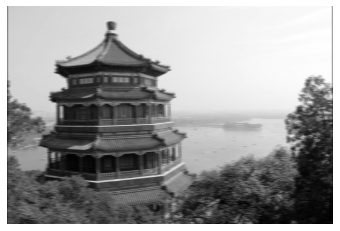

In [3]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image('china.jpg') / 255   # scale features by dividing by 255
flower = load_sample_image('flower.jpg') / 255

images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 (7 × 7) filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

plt.imshow(outputs[0, :, :, 1], cmap='gray')   # plot 1st image's 2nd feature map
plt.axis('off')
plt.show()

The tf.nn.conv2d() line deserves a bit more explanation:
* images is the input mini-batch (a 4D tensor, as explained earlier).
* filters is the set of filters to apply (also a 4D tensor, as explained earlier).
* strides is equal to 1, but it could also be a 1D array with four elements, where the two central elements are the vertical and horizontal strides ($s_{h}$ and $s_{w}$).
* padding must be either "SAME" or "VALID":
  1. If set to "SAME", the convolutional layer uses zero padding if necessary. The output size is set to the number of input neurons divided by the stride, rounded up.
  2. If set to "VALID", the convolutional layer does not use zero padding and may ignore some rows and columns at the bottom and right of the input image, depending on the stride.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/padding-same-valid.png?raw=1' width='800'/>

In this example we manually defined the filters, but in a real CNN you would normally define filters as trainable variables so the neural net can learn which filters work best, as explained earlier. Instead of manually creating the variables, use the keras.layers.Conv2D layer:

```python
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
padding="same", activation="relu")
```

This code creates a Conv2D layer with 32 filters, each 3 × 3, using a stride of 1 (both horizontally and vertically) and "same" padding, and applying the ReLU activation function to its outputs. As you can see, convolutional layers have quite a few hyperparameters: you must choose the number of filters, their height and width, the strides, and the padding type.

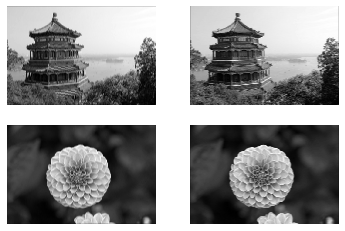

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

## Pooling Layers

Once you understand how convolutional layers work, the pooling layers are quite easy to grasp. Their goal is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting).

Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. You must define its size, the stride, and the padding type, just like before. 

However, a pooling neuron has no weights; all it does is aggregate the
inputs using an aggregation function such as the max or mean.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/max-pooling-layer.png?raw=1' width='800'/>

We use a 2 × 2 pooling kernel with a stride of 2 and no padding. Only the max input value in each receptive field makes it to the next layer, while the other inputs are dropped. 

For example, in the lower-left receptive field, the input values are 1, 5, 3, 2, so only the max value, 5, is propagated to the next layer. Because of the stride of 2, the output image has half the height and half the width of the input image(rounded down since we use no padding).

Other than reducing computations, memory usage, and the number of parameters, a max pooling layer also introduces some level of invariance to small translations.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/translation-invariance.png?raw=1' width='800'/>

Here we assume that the bright pixels have a lower value than
dark pixels, and we consider three images (A, B, C) going through a max pooling layer with a 2 × 2 kernel and stride 2. Images B and C are the same as image A, but shifted by one and two pixels to the right. 

As you can see, the outputs of the max pooling layer for images A and B are identical. This is what translation invariance means. For image C, the output is different: it is shifted one pixel to the right (but
there is still 75% invariance). 

By inserting a max pooling layer every few layers in a CNN, it is possible to get some level of translation invariance at a larger scale. Moreover,
max pooling offers a small amount of rotational invariance and a slight scale invariance. Such invariance (even if it is limited) can be useful in cases where the prediction should not depend on these details, such as in classification tasks.

However, max pooling has some downsides too. Firstly, it is obviously very destructive: even with a tiny 2 × 2 kernel and a stride of 2, the output will be two times smaller in both directions (so its area will be four times smaller), simply dropping 75% of the input values. And in some applications, invariance is not desirable. 

Take semantic segmentation (the task of classifying each pixel in an image according to the object that pixel belongs to): obviously, if the input image is translated by one pixel to the right, the output should also be translated by one pixel to the right. The goal in this case is equivariance, not invariance: a small change to the inputs should lead to a corresponding small change in the output.



## TensorFlow Implementation

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/depthwise-max-pooling.png?raw=1' width='800'/>